<a href="https://colab.research.google.com/github/andrew-na-git/Stable-Diffusion/blob/William_branch/Colour_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# !make -C sparse_gaussian_elimination a.so

In [9]:
#@title Preamble
import os
import threading
import torch.multiprocessing as multiprocessing
import functools
import random
from math import log, sqrt, exp

import matplotlib.pyplot as plt
import scipy.stats as stats

import numpy as np
import scipy as sp
from tqdm import tqdm
from scipy import sparse
from scipy.special import logsumexp, softmax, log_softmax
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

import torch
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.optim import Adam, AdamW, SGD

from kfp import construct_A, construct_B, diffusion_coeff, marginal_prob_std, construct_R, construct_P, construct_P_block, construct_R_block, gauss_seidel, jacobi #  solve_pde
from network2 import Model

import PIL

np.random.seed(2)
torch.manual_seed(2)

#torch.set_default_device('cuda')

# create a.so if doesnt exists
# if not os.path.isfile("../sparse_gaussian_elimination/a.so"):
#     os.system("make -C ../sparse_gaussian_elimination a.so")
cifar = CIFAR10('.', download=True)

Files already downloaded and verified


In [10]:
#@title Construct the grid and Initial values
batch_size = 1 #@param
N = 20 #@param
H = 32 #@param
W = 32 #@param
epoch = 300 #@param
eps = 1e-6 #@param
lr = 1e-3 #@param

channels = 3
dt = 1/N
sigma = 25 #@param
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [11]:
#@title Download mnist dataset
#data_loader = DataLoader(list(filter(lambda i: i[1] == 5, mnist))[:1], shuffle=True, generator=torch.Generator(device='cuda'))
cifar_data = cifar.data[np.array(cifar.targets) == 5] # grab the fives

# sample 5 images for training
cifar_data = cifar_data[np.random.choice(list(range(len(cifar_data))), 3, replace=False)]

218 0


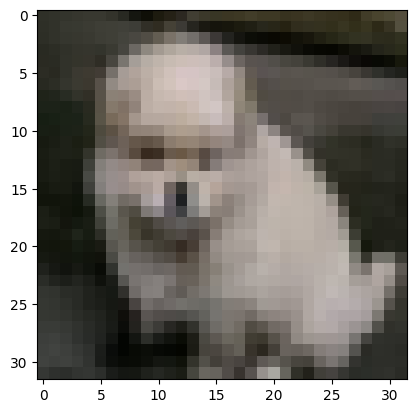

1.0 0.0


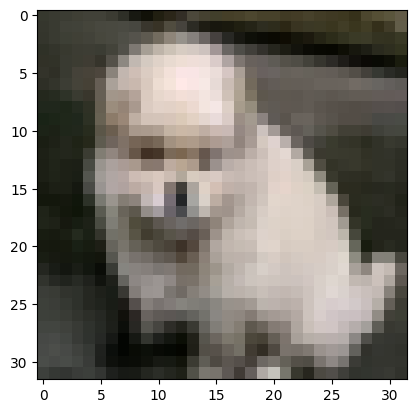

237 7


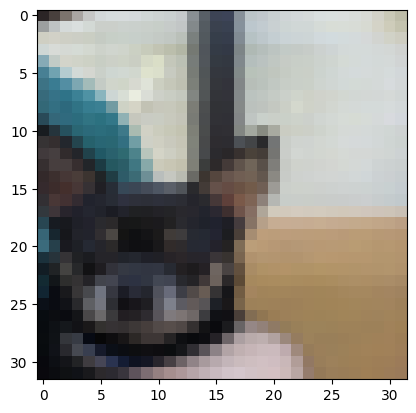

1.0 0.0


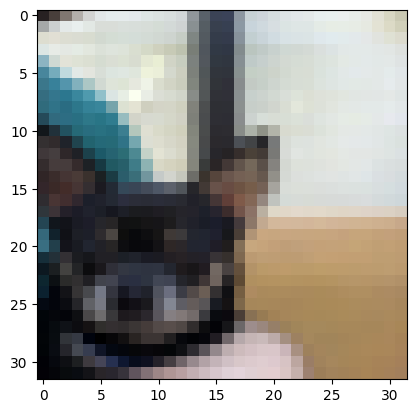

235 10


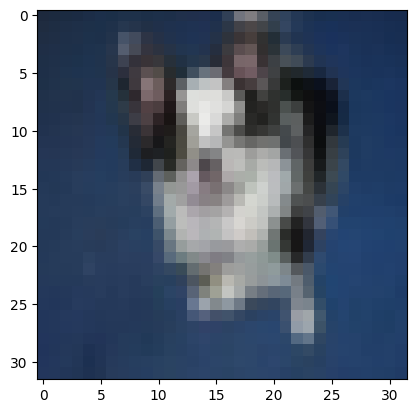

1.0 0.0


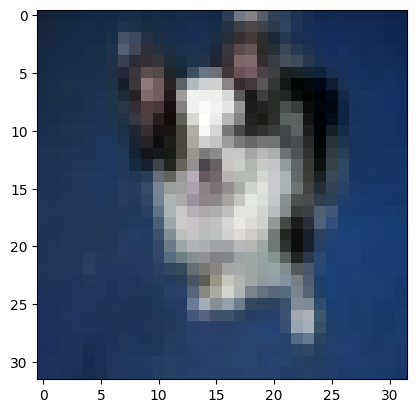

In [12]:
#@title Cropping the image
cropped_image_g = np.array(PIL.Image.fromarray(np.array(cifar_data[0])).convert("L").crop((0, 0, 32, 32)))
cifar_data_list_grey = [torch.Tensor(cropped_image_g)]

cifar_data_list = []
cifar_data_list_tensor = []
for i in range(3):
  cropped_image_rgb = np.array(PIL.Image.fromarray(np.array(cifar_data[i])).convert("RGB").crop((0, 0, 32, 32)))
  cifar_data_list.append((cropped_image_rgb - cropped_image_rgb.min())/(cropped_image_rgb.max() - cropped_image_rgb.min())) # normalized to [0, 1]
  # cifar_data_list = [cropped_image_rgb]
  cifar_data_list_tensor.append(torch.Tensor(cifar_data_list[i].transpose((2, 0, 1))))

  print(cifar_data[i].max(), cifar_data[i].min())
  plt.imshow(cifar_data[i])
  plt.show()

  print(cifar_data_list[i].max(), cifar_data_list[i].min())
  plt.imshow((cifar_data_list[i] - cifar_data_list[i].min())/(cifar_data_list[i].max() - cifar_data_list[i].min()))
  plt.show()

In [13]:
#@title Defining pde diffusion per thread
import cupy as cp
from cupyx.scipy.sparse import csr_matrix as cp_csr
from cupyx.scipy.sparse import linalg as cp_linalg

def diffuse(initial_m, m, dm, channel, time_, g, scores):

  m[0, channel] = initial_m[channel]
  dh = 1 # 256/(H*W)

  A_block = []
  for i in range(1, N):
    A = construct_A(H, W, dt/(2*dh), dt/(dh**2), 0, 0, g(time_[i]), scores[i, channel])#H,W,dh,dh2,f,g,s
    A_block.append(sparse.csr_matrix(A))

  A_block = sparse.block_diag(A_block, format='csr')
  A_block = A_block.toarray()

  for i in range(2, N):
    A_block[(i-1)*(H*W):i*(H*W), (i-2)*(H*W):(i-1)*(H*W)] = -np.eye(H*W)

  B_block = np.zeros(((N-1)*H*W))
  B_block[:H*W] = construct_B(H, W, m[0, channel])

  pde_sol = cp_linalg.spsolve(cp_csr(cp.array(A_block)), cp.array(B_block))
  m[1:, channel] = cp.asnumpy(pde_sol).reshape((-1, H*W))

  del pde_sol
  cp._default_memory_pool.free_all_blocks()

  img_log_prob = m[:, channel]
  dm[:, channel, 1:-1] = (img_log_prob[:, 2:] - img_log_prob[:, :-2])/(2*dh) # (img_log_prob[:, 1:-1, 2:] - img_log_prob[:, 1:-1, :-2])/(2*dy)
  dm[:, channel, 0] = (img_log_prob[:, 1] - 0)/(2*dh) #+ (img_log_prob[:, 1:-1, 0] - img_log_prob[:, 1:-1, -1])/dy
  dm[:, channel, -1] = (0 - img_log_prob[:, -2])/(2*dh) #+ (img_log_prob[:, 1:-1, -1] - img_log_prob[:, 1:-1, 0])/dy
  # dm[:, channel, 0 , 1:-1] = (img_log_prob[:, 0, 2:] - img_log_prob[:, 0, :-2])/(2*dy) + (img_log_prob[:, 0, 1:-1] - img_log_prob[:, -1, 1:-1])/dx
  # dm[:, channel, -1 , 1:-1] = (img_log_prob[:, -1, 2:] - img_log_prob[:, -1, :-2])/(2*dy) + (img_log_prob[:, -1, 1:-1] - img_log_prob[:, 0, 1:-1])/dx

In [14]:
#@title Precompute score labels by solving the PDE
tol = 1e-3 #@param
max_iter = 1000 #@param

if not os.path.exists('scores_label'):
  scores_label = []
  init_m_batch = []
  for idx, data in tqdm(enumerate(cifar_data_list_tensor)):
    y_train = []
    for j in range(H):
      y_train.append(data[:, j, :])
    y_train = np.concatenate(y_train, axis=-1)

    x_train = []
    for l in range(W):
      x_train.append(data[:, :, l])
    x_train = np.concatenate(x_train, axis=1)

    init_m = []
    for ch in range(channels):
      xy_train = np.vstack([x_train[ch], y_train[ch]])
      kde_kernel = stats.gaussian_kde(xy_train)
      init_m.append(kde_kernel.logpdf(xy_train)[None])

    init_m = np.concatenate(init_m)
    init_m_batch.append(init_m[None])
  init_m_batch = np.concatenate(init_m_batch)

  for idx, data in enumerate(cifar_data_list_tensor):

    m = np.zeros((N, channels, H*W), dtype=np.float32)
    m_prev = np.zeros((N, channels, H*W), dtype=np.float32)
    scores = np.zeros((N, channels, H*W), dtype=np.float32) # initial scores guess
    dm = np.zeros_like(scores, dtype=np.float32)

    res = 1
    e = 0
    while res > tol:
      res_prev = res
      # we want to sample from random time steps to construct training samples
      time_ = np.linspace(eps, 1., N) + idx
      print(time_.max(), time_.min())
      # diffuse all three channels concurrently
      for ch in tqdm(range(channels)):
        diffuse(init_m_batch[idx], m, dm, ch, time_, diffusion_coeff_fn, scores)

      scores = dm.copy()

      if e == max_iter:
        print(f'No convergence')
        break

      res = np.linalg.norm(m - m_prev)
      print(f'residual at iteration {e}: {res}')

      m_prev = m.copy()
      e += 1

      if abs(res_prev - res) < 1e-6:
        break

    scores_label.append(scores.copy().reshape((1, -1, channels, H, W)))
  scores_label = np.concatenate(scores_label)
  print(scores_label.shape)

3it [00:00,  6.34it/s]


1.0 1e-06


100%|██████████| 3/3 [00:12<00:00,  4.22s/it]


residual at iteration 0: 81.05345916748047
1.0 1e-06


100%|██████████| 3/3 [00:12<00:00,  4.16s/it]


residual at iteration 1: 1.4085259437561035
1.0 1e-06


100%|██████████| 3/3 [00:12<00:00,  4.30s/it]


residual at iteration 2: 0.08602911978960037
1.0 1e-06


100%|██████████| 3/3 [00:12<00:00,  4.13s/it]


residual at iteration 3: 0.004769359715282917
1.0 1e-06


100%|██████████| 3/3 [00:12<00:00,  4.08s/it]


residual at iteration 4: 0.00031962268985807896
2.0 1.000001


100%|██████████| 3/3 [00:12<00:00,  4.26s/it]


residual at iteration 0: 32.59004592895508
2.0 1.000001


100%|██████████| 3/3 [00:12<00:00,  4.20s/it]


residual at iteration 1: 0.00019466991943772882
3.0 2.000001


100%|██████████| 3/3 [00:12<00:00,  4.19s/it]


residual at iteration 0: 125.98403930664062
3.0 2.000001


100%|██████████| 3/3 [00:12<00:00,  4.18s/it]

residual at iteration 1: 4.755137172907098e-09
(3, 20, 3, 32, 32)


In [ ]:
#@title Show the score labels
import pickle
if os.path.exists(f'scores_label'):
  with open('/content/scores_label', 'rb') as file:
    scores_label = pickle.load(file)

for idx in range(3):
  print(scores_label[idx][0].max(), scores_label[idx][0].min())
  plt.imshow(((scores_label[idx][0] - scores_label[idx][0].min())/(scores_label[idx][0].max() - scores_label[idx][0].min())).transpose(1, 2, 0))
  plt.show()
  print(scores_label[idx][-1].max(), scores_label[idx][-1].min())
  plt.imshow(((scores_label[idx][-1] - scores_label[idx][-1].min())/(scores_label[idx][-1].max() - scores_label[idx][-1].min())).transpose(1, 2, 0))
  plt.show()

In [16]:
import pickle
if not os.path.exists('scores_label'):
  with open('/content/scores_label', 'wb') as file:
    pickle.dump(scores_label, file)

In [17]:
#@title Denoising network training
def loss_fn(model, x, label, diffusion_coeff, marginal_prob_std, idx=1, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  random_t = torch.tensor(np.sort(np.random.uniform(eps + idx, 1. + idx, N)).astype(np.float32))
  # we encode the label into the initial data using the reverse ODE
  diff_std2 = diffusion_coeff(2 * random_t)
  for i in range(1, N):
    x[i] = x[i-1] - 0.5 * ((label[i-1] + label[i])/2) * ((diff_std2[i-1] + diff_std2[i])/2) * dt
  std = marginal_prob_std(random_t)
  z = torch.randn_like(x)
  # we perturb the image by the forward SDE conditional distribution
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t)
  # loss = torch.mean((diff_std2) * torch.sum((score * std[:, None, None, None] - label)**2, dim=(1, 2, 3)) / (2 * diff_std2))
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1, 2, 3))) # original loss from tutorial
  return loss

In [18]:
#@title Function for training on a thread
def diffuse_train(init_x, epoch, diffusion_coeff, marginal_prob_std, label, losses, model_score, optimizer, idx=1):
  scores_label = torch.tensor(label)

  loss = loss_fn(model_score, init_x, scores_label, diffusion_coeff, marginal_prob_std, idx)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  losses.append(loss)

In [ ]:
#@title Training the score-network
if os.path.exists(f'model_cifar.pth'):
  print(f'removing saved weights\n')
  os.remove(f'model_cifar.pth')

init_x = torch.zeros((N, channels, H, W))

model_score = Model()
optimizer = Adam(model_score.parameters(), lr=lr)
model_score.train();

for e in tqdm(range(epoch)):
  losses = []
  for idx, data in enumerate(cifar_data_list_tensor):

    for i in range(N):
      init_x[i] = data

    diffuse_train(init_x, epoch, diffusion_coeff_fn, marginal_prob_std_fn, scores_label[idx], losses, model_score, optimizer, idx)

    print(f'\nloss: {losses[idx]}')

file = f'model_cifar.pth'
torch.save(model_score.state_dict(), file)
print(f"model has been saved\n")

  0%|          | 0/300 [00:00<?, ?it/s]


loss: 6953.4111328125

loss: 1977401.75


  0%|          | 1/300 [00:06<34:00,  6.82s/it]


loss: 1394463872.0

loss: 9348.783203125

loss: 1558213.75


  1%|          | 2/300 [00:13<34:12,  6.89s/it]


loss: 1111273984.0

loss: 8071.7451171875

loss: 989565.6875


  1%|          | 3/300 [00:19<32:14,  6.51s/it]


loss: 437438144.0

loss: 7071.08349609375

loss: 629748.1875


  1%|▏         | 4/300 [00:27<33:51,  6.86s/it]


loss: 373207552.0

loss: 5605.9853515625

loss: 1004829.0


  2%|▏         | 5/300 [00:33<32:34,  6.63s/it]


loss: 430097600.0

loss: 6195.7841796875

loss: 406912.25


  2%|▏         | 6/300 [00:40<33:05,  6.75s/it]


loss: 349141056.0

loss: 4198.763671875

loss: 522163.3125


  2%|▏         | 7/300 [00:46<32:01,  6.56s/it]


loss: 319566880.0

loss: 5355.0234375

loss: 634364.25


  3%|▎         | 8/300 [00:53<32:37,  6.70s/it]


loss: 381069760.0

loss: 5080.8837890625

loss: 574791.625


  3%|▎         | 9/300 [00:59<31:34,  6.51s/it]


loss: 185384368.0

loss: 4401.7490234375

loss: 390004.75


  3%|▎         | 10/300 [01:07<32:55,  6.81s/it]


loss: 229437904.0

loss: 5947.4755859375

loss: 310203.0625


  4%|▎         | 11/300 [01:13<32:18,  6.71s/it]


loss: 162236608.0

loss: 4702.3486328125

loss: 624343.0625


  4%|▍         | 12/300 [01:20<32:11,  6.71s/it]


loss: 152849584.0

loss: 4459.71875

loss: 380740.4375


  4%|▍         | 13/300 [01:27<32:11,  6.73s/it]


loss: 128564864.0

loss: 4469.421875

loss: 449665.0625


  5%|▍         | 14/300 [01:34<32:20,  6.79s/it]


loss: 108030888.0

loss: 4183.7900390625

loss: 417004.6875


  5%|▌         | 15/300 [01:41<33:09,  6.98s/it]


loss: 127518032.0

loss: 3490.25390625

loss: 278355.5


  5%|▌         | 16/300 [01:48<33:05,  6.99s/it]


loss: 217398064.0

loss: 3511.623779296875

loss: 451208.5


  6%|▌         | 17/300 [01:55<33:19,  7.06s/it]


loss: 552563904.0

loss: 4224.8701171875

loss: 401454.84375


  6%|▌         | 18/300 [02:01<31:58,  6.80s/it]


loss: 58345912.0

loss: 4464.36279296875

loss: 272179.5


  6%|▋         | 19/300 [02:09<33:29,  7.15s/it]


loss: 137678912.0

loss: 4939.1513671875

loss: 349210.375


  7%|▋         | 20/300 [02:16<32:29,  6.96s/it]


loss: 100576496.0

loss: 5099.66455078125

loss: 232382.203125


  7%|▋         | 21/300 [02:23<32:29,  6.99s/it]


loss: 125082304.0

loss: 4515.30517578125

loss: 115276.484375


  7%|▋         | 22/300 [02:29<31:29,  6.80s/it]


loss: 31929804.0

loss: 4767.28125

loss: 98446.1953125


  8%|▊         | 23/300 [02:36<31:13,  6.76s/it]


loss: 435362816.0

loss: 4494.51416015625

loss: 425220.1875


  8%|▊         | 24/300 [02:43<31:16,  6.80s/it]


loss: 232707664.0

loss: 4120.3603515625

loss: 370852.46875


  8%|▊         | 25/300 [02:50<31:11,  6.81s/it]


loss: 226768864.0

loss: 4773.0498046875

loss: 231379.453125


  9%|▊         | 26/300 [02:57<31:32,  6.91s/it]


loss: 136312816.0

loss: 3903.30078125

loss: 193217.578125


  9%|▉         | 27/300 [03:03<30:38,  6.74s/it]


loss: 86608056.0

loss: 4245.55810546875

loss: 283276.4375


  9%|▉         | 28/300 [03:10<30:57,  6.83s/it]


loss: 264559824.0

loss: 5100.75927734375

loss: 1117653.25


 10%|▉         | 29/300 [03:17<30:11,  6.69s/it]


loss: 578562368.0

loss: 3521.08056640625

loss: 219838.34375


 10%|█         | 30/300 [03:24<30:38,  6.81s/it]


loss: 314072992.0

loss: 4182.70068359375

loss: 167424.0


 10%|█         | 31/300 [03:31<30:38,  6.84s/it]


loss: 329199328.0

loss: 4240.2314453125

loss: 344781.03125


 11%|█         | 32/300 [03:38<31:17,  7.01s/it]


loss: 117093480.0

loss: 4498.3681640625

loss: 307912.4375


 11%|█         | 33/300 [03:44<30:21,  6.82s/it]


loss: 257776672.0

loss: 3944.7890625

loss: 154354.984375


 11%|█▏        | 34/300 [03:52<31:08,  7.02s/it]


loss: 480079616.0

loss: 3664.957763671875

loss: 363499.71875


 12%|█▏        | 35/300 [03:59<31:24,  7.11s/it]


loss: 493148736.0

loss: 3680.341064453125

loss: 630273.625


 12%|█▏        | 36/300 [04:07<31:39,  7.20s/it]


loss: 748720320.0

loss: 3829.4765625

loss: 554056.5625


 12%|█▏        | 37/300 [04:14<32:01,  7.30s/it]


loss: 479321664.0

loss: 4974.82666015625

loss: 1345959.625


 13%|█▎        | 38/300 [04:21<30:56,  7.09s/it]


loss: 1736690048.0

loss: 3496.259765625

loss: 423895.09375


 13%|█▎        | 39/300 [04:29<32:11,  7.40s/it]


loss: 1249083648.0

loss: 4034.960205078125

loss: 404685.8125


 13%|█▎        | 40/300 [04:36<31:30,  7.27s/it]


loss: 479521696.0

loss: 3558.983642578125

loss: 506599.84375


 14%|█▎        | 41/300 [04:43<31:52,  7.38s/it]


loss: 292653888.0

loss: 3851.93896484375

loss: 526374.0


 14%|█▍        | 42/300 [04:51<31:37,  7.35s/it]


loss: 675206208.0

loss: 3379.07421875

loss: 153616.203125


 14%|█▍        | 43/300 [04:58<31:19,  7.31s/it]


loss: 357670848.0

loss: 3579.02734375

loss: 293305.5625


 15%|█▍        | 44/300 [05:06<31:37,  7.41s/it]


loss: 549715264.0

loss: 3603.581298828125

loss: 290032.1875


 15%|█▌        | 45/300 [05:12<30:39,  7.21s/it]


loss: 79104664.0

loss: 3125.56591796875

loss: 246767.171875


 15%|█▌        | 46/300 [05:20<30:29,  7.20s/it]


loss: 165646048.0

loss: 3710.576904296875

loss: 630450.1875


 16%|█▌        | 47/300 [05:26<29:19,  6.95s/it]


loss: 225322448.0

loss: 3484.809326171875

loss: 456184.25


 16%|█▌        | 48/300 [05:33<29:17,  6.97s/it]


loss: 214300384.0

loss: 3213.671142578125

loss: 42734.13671875


 16%|█▋        | 49/300 [05:40<28:46,  6.88s/it]


loss: 47902308.0

loss: 3281.93505859375

loss: 653791.3125


 17%|█▋        | 50/300 [05:47<29:15,  7.02s/it]


loss: 254872832.0

loss: 3463.06494140625

loss: 345993.125


 17%|█▋        | 51/300 [05:53<28:04,  6.76s/it]


loss: 234650672.0

loss: 3224.043701171875

loss: 32036.01953125


 17%|█▋        | 52/300 [06:00<28:35,  6.92s/it]


loss: 16620165.0

loss: 3194.417236328125

loss: 150732.09375


 18%|█▊        | 53/300 [06:07<28:22,  6.89s/it]


loss: 196571376.0

loss: 3225.040283203125

loss: 91530.015625


 18%|█▊        | 54/300 [06:14<28:30,  6.95s/it]


loss: 69009584.0

loss: 3215.42626953125

loss: 29713.384765625


 18%|█▊        | 55/300 [06:21<28:33,  6.99s/it]


loss: 29156772.0

loss: 3122.19091796875

loss: 16870.17578125


 19%|█▊        | 56/300 [06:28<27:58,  6.88s/it]


loss: 105750264.0

loss: 3107.92431640625

loss: 51498.8984375


 19%|█▉        | 57/300 [06:35<28:06,  6.94s/it]


loss: 7937651.0

loss: 3218.053466796875

loss: 91881.421875


 19%|█▉        | 58/300 [06:41<27:11,  6.74s/it]


loss: 44717368.0

loss: 3180.795654296875

loss: 101060.359375


 20%|█▉        | 59/300 [06:49<27:47,  6.92s/it]


loss: 25437468.0

loss: 3124.768798828125

loss: 25103.087890625


 20%|██        | 60/300 [06:55<27:22,  6.84s/it]


loss: 9525679.0

loss: 3107.624755859375

loss: 32265.09375


 20%|██        | 61/300 [07:03<27:40,  6.95s/it]


loss: 31133984.0

loss: 3136.020751953125

loss: 47722.5390625


 21%|██        | 62/300 [07:09<27:06,  6.83s/it]


loss: 1158545.25

loss: 3153.125

loss: 50615.3203125


 21%|██        | 63/300 [07:17<28:10,  7.13s/it]


loss: 12144946.0

loss: 3198.814208984375

loss: 43424.41015625


 21%|██▏       | 64/300 [07:24<27:49,  7.08s/it]


loss: 6834044.0

loss: 3174.479736328125

loss: 52767.48046875


 22%|██▏       | 65/300 [07:31<27:58,  7.14s/it]


loss: 4116302.5

loss: 3102.02587890625

loss: 24553.70703125


 22%|██▏       | 66/300 [07:39<28:03,  7.20s/it]


loss: 3167664.25

loss: 3083.21826171875

loss: 34876.84375


 22%|██▏       | 67/300 [07:46<28:02,  7.22s/it]


loss: 3427774.5

loss: 3109.367919921875

loss: 24275.98828125


 23%|██▎       | 68/300 [07:54<28:39,  7.41s/it]


loss: 2722504.25

loss: 3181.912109375

loss: 29370.51171875


 23%|██▎       | 69/300 [08:01<27:58,  7.27s/it]


loss: 1490407.125

loss: 3113.279296875

loss: 31873.12109375


 23%|██▎       | 70/300 [08:09<28:45,  7.50s/it]


loss: 964899.3125

loss: 3116.45166015625

loss: 39258.42578125


 24%|██▎       | 71/300 [08:16<28:31,  7.48s/it]


loss: 2690282.5

loss: 3117.26123046875

loss: 35476.2578125


 24%|██▍       | 72/300 [08:23<28:00,  7.37s/it]


loss: 942142.625

loss: 3128.673095703125

loss: 24108.30078125


 24%|██▍       | 73/300 [08:30<27:28,  7.26s/it]


loss: 2118315.5

loss: 3139.05859375

loss: 21098.48046875


 25%|██▍       | 74/300 [08:37<26:43,  7.10s/it]


loss: 1893224.25

loss: 3109.658447265625

loss: 15524.650390625


 25%|██▌       | 75/300 [08:44<26:47,  7.15s/it]


loss: 708984.875

loss: 3137.779296875

loss: 17183.224609375


 25%|██▌       | 76/300 [08:51<26:08,  7.00s/it]


loss: 648916.9375

loss: 3164.25537109375

loss: 29118.97265625


 26%|██▌       | 77/300 [08:58<26:32,  7.14s/it]


loss: 2218168.25

loss: 3131.20751953125

loss: 43887.46875


 26%|██▌       | 78/300 [09:04<25:22,  6.86s/it]


loss: 2301936.25

loss: 3143.067138671875

loss: 25873.244140625


 26%|██▋       | 79/300 [09:11<25:25,  6.90s/it]


loss: 633915.125

loss: 3157.306640625

loss: 19280.78515625


 27%|██▋       | 80/300 [09:18<24:46,  6.76s/it]


loss: 1158715.125

loss: 3097.672607421875

loss: 14557.6767578125


 27%|██▋       | 81/300 [09:25<25:03,  6.87s/it]


loss: 968275.5

loss: 3121.12255859375

loss: 24733.3515625


 27%|██▋       | 82/300 [09:32<24:46,  6.82s/it]


loss: 1303196.25

loss: 3105.025634765625

loss: 19573.94140625


 28%|██▊       | 83/300 [09:39<24:52,  6.88s/it]


loss: 1076599.125

loss: 3116.76318359375

loss: 29415.46484375


 28%|██▊       | 84/300 [09:46<24:43,  6.87s/it]


loss: 909064.625

loss: 3111.5908203125

loss: 37825.0


 28%|██▊       | 85/300 [09:52<24:22,  6.80s/it]


loss: 1045006.8125

loss: 3179.70361328125

loss: 18627.41015625


 29%|██▊       | 86/300 [10:00<24:52,  6.97s/it]


loss: 682805.75

loss: 3064.90966796875

loss: 22468.51953125


 29%|██▉       | 87/300 [10:07<24:44,  6.97s/it]


loss: 1638806.75

loss: 3097.89208984375

loss: 32359.41796875


 29%|██▉       | 88/300 [10:14<25:10,  7.12s/it]


loss: 871316.625

loss: 3098.56298828125

loss: 24483.470703125


 30%|██▉       | 89/300 [10:21<24:42,  7.03s/it]


loss: 619371.75

loss: 3151.025146484375

loss: 29299.046875


 30%|███       | 90/300 [10:28<25:07,  7.18s/it]


loss: 763983.875

loss: 3112.43798828125

loss: 20182.99609375


 30%|███       | 91/300 [10:35<24:31,  7.04s/it]


loss: 515565.09375

loss: 3146.659912109375

loss: 22992.474609375


 31%|███       | 92/300 [10:43<25:02,  7.23s/it]


loss: 471276.15625

loss: 3140.90771484375

loss: 13704.0498046875


 31%|███       | 93/300 [10:50<24:47,  7.19s/it]


loss: 951585.375

loss: 3118.147705078125

loss: 32506.212890625


 31%|███▏      | 94/300 [10:57<24:37,  7.17s/it]


loss: 769088.5

loss: 3172.32666015625

loss: 16108.7109375


 32%|███▏      | 95/300 [11:05<24:54,  7.29s/it]


loss: 539988.0625

loss: 3093.642822265625

loss: 27021.90625


 32%|███▏      | 96/300 [11:11<24:00,  7.06s/it]


loss: 672487.25

loss: 3116.980224609375

loss: 22407.373046875


 32%|███▏      | 97/300 [11:18<24:03,  7.11s/it]


loss: 436467.40625

loss: 3145.906494140625

loss: 24810.75390625


 33%|███▎      | 98/300 [11:25<23:12,  6.89s/it]


loss: 880999.5

loss: 3203.925537109375

loss: 31228.978515625


 33%|███▎      | 99/300 [11:32<23:19,  6.96s/it]


loss: 573328.0625

loss: 3134.99853515625

loss: 19397.990234375


 33%|███▎      | 100/300 [11:38<22:38,  6.79s/it]


loss: 418422.40625

loss: 3144.74951171875

loss: 16583.974609375


 34%|███▎      | 101/300 [11:45<22:54,  6.91s/it]


loss: 491265.90625

loss: 3115.823974609375

loss: 33137.33984375


 34%|███▍      | 102/300 [11:52<22:12,  6.73s/it]


loss: 140374.28125

loss: 3130.0537109375

loss: 15762.212890625


 34%|███▍      | 103/300 [11:59<22:30,  6.86s/it]


loss: 583790.75

loss: 3109.6181640625

loss: 21591.23046875


 35%|███▍      | 104/300 [12:05<22:08,  6.78s/it]


loss: 317207.09375

loss: 3122.337646484375

loss: 28347.974609375


 35%|███▌      | 105/300 [12:12<21:58,  6.76s/it]


loss: 336479.40625

loss: 3177.849365234375

loss: 19637.73828125


 35%|███▌      | 106/300 [12:19<22:05,  6.83s/it]


loss: 565798.875

loss: 3155.667236328125

loss: 21933.458984375


 36%|███▌      | 107/300 [12:26<21:40,  6.74s/it]


loss: 470998.90625

loss: 3117.4501953125

loss: 22227.212890625


 36%|███▌      | 108/300 [12:33<21:58,  6.87s/it]


loss: 746916.375

loss: 3077.811279296875

loss: 21703.87890625


 36%|███▋      | 109/300 [12:39<21:29,  6.75s/it]


loss: 407488.78125

loss: 3144.8359375

loss: 24169.146484375


 37%|███▋      | 110/300 [12:47<21:53,  6.91s/it]


loss: 869160.875

loss: 3152.253662109375

loss: 25086.78125


 37%|███▋      | 111/300 [12:53<21:16,  6.75s/it]


loss: 854830.6875

loss: 3143.87255859375

loss: 25662.994140625


 37%|███▋      | 112/300 [13:00<21:33,  6.88s/it]


loss: 550509.9375

loss: 3114.33056640625

loss: 20344.396484375


 38%|███▊      | 113/300 [13:06<20:54,  6.71s/it]


loss: 387261.90625

loss: 3096.916015625

loss: 13329.6044921875


 38%|███▊      | 114/300 [13:13<21:02,  6.79s/it]


loss: 810938.3125

loss: 3107.119873046875

loss: 26191.9140625


 38%|███▊      | 115/300 [13:20<20:33,  6.67s/it]


loss: 633705.125

loss: 3161.8798828125

loss: 14859.9189453125


 39%|███▊      | 116/300 [13:27<20:53,  6.81s/it]


loss: 596762.625

loss: 3110.523681640625

loss: 24281.44140625


 39%|███▉      | 117/300 [13:34<20:33,  6.74s/it]


loss: 626723.375

loss: 3086.263427734375

loss: 13696.970703125


 39%|███▉      | 118/300 [13:40<20:28,  6.75s/it]


loss: 505517.09375

loss: 3102.393798828125

loss: 17569.99609375


 40%|███▉      | 119/300 [13:47<20:30,  6.80s/it]


loss: 593417.3125

loss: 3142.442626953125

loss: 20669.470703125


 40%|████      | 120/300 [13:54<20:09,  6.72s/it]


loss: 506460.84375

loss: 3130.99169921875

loss: 20592.72265625


 40%|████      | 121/300 [14:01<20:25,  6.85s/it]


loss: 474476.75

loss: 3109.1298828125

loss: 11478.6142578125


 41%|████      | 122/300 [14:07<19:44,  6.65s/it]


loss: 589714.375

loss: 3163.58349609375

loss: 13346.796875


 41%|████      | 123/300 [14:14<20:06,  6.82s/it]


loss: 622110.875

loss: 3197.190673828125

loss: 19724.3046875


 41%|████▏     | 124/300 [14:21<19:42,  6.72s/it]


loss: 594054.5625

loss: 3162.338623046875

loss: 18413.263671875


 42%|████▏     | 125/300 [14:28<19:56,  6.84s/it]


loss: 400690.84375

loss: 3142.174560546875

loss: 19433.79296875


 42%|████▏     | 126/300 [14:34<19:21,  6.68s/it]


loss: 363111.84375

loss: 3112.06787109375

loss: 21627.26953125


 42%|████▏     | 127/300 [14:41<19:32,  6.78s/it]


loss: 768072.0625

loss: 3149.600830078125

loss: 14901.9013671875


 43%|████▎     | 128/300 [14:48<19:06,  6.66s/it]


loss: 413614.40625

loss: 3092.57568359375

loss: 15959.224609375


 43%|████▎     | 129/300 [14:55<19:22,  6.80s/it]


loss: 486916.90625

loss: 3145.83740234375

loss: 14164.75


 43%|████▎     | 130/300 [15:01<19:00,  6.71s/it]


loss: 593481.8125

loss: 3114.692626953125

loss: 22755.255859375


 44%|████▎     | 131/300 [15:08<19:07,  6.79s/it]


loss: 650820.75

loss: 3186.153076171875

loss: 12619.611328125


 44%|████▍     | 132/300 [15:15<19:04,  6.81s/it]


loss: 265950.75

loss: 3137.712890625

loss: 26275.25


 44%|████▍     | 133/300 [15:22<18:55,  6.80s/it]


loss: 340531.8125

loss: 3118.9833984375

loss: 10250.427734375


 45%|████▍     | 134/300 [15:29<19:06,  6.91s/it]


loss: 382466.78125

loss: 3168.99609375

loss: 19044.30859375


 45%|████▌     | 135/300 [15:35<18:31,  6.74s/it]


loss: 1161912.0

loss: 3098.08837890625

loss: 17123.15234375


 45%|████▌     | 136/300 [15:42<18:41,  6.84s/it]


loss: 421247.9375

loss: 3071.87548828125

loss: 15354.46875


 46%|████▌     | 137/300 [15:49<18:08,  6.68s/it]


loss: 575064.625

loss: 3115.74169921875

loss: 10912.9013671875


 46%|████▌     | 138/300 [15:56<18:26,  6.83s/it]


loss: 692931.5

loss: 3156.839599609375

loss: 15779.921875


 46%|████▋     | 139/300 [16:02<18:00,  6.71s/it]


loss: 539536.375

loss: 3086.376953125

loss: 19741.072265625


 47%|████▋     | 140/300 [16:10<18:13,  6.84s/it]


loss: 291524.75

loss: 3150.731201171875

loss: 9363.162109375


 47%|████▋     | 141/300 [16:16<17:50,  6.73s/it]


loss: 691845.4375

loss: 3149.01220703125

loss: 15522.693359375


 47%|████▋     | 142/300 [16:23<18:11,  6.91s/it]


loss: 619906.75

loss: 3098.80908203125

loss: 12100.2744140625


 48%|████▊     | 143/300 [16:30<17:55,  6.85s/it]


loss: 300093.9375

loss: 3138.018310546875

loss: 14109.650390625


 48%|████▊     | 144/300 [16:37<18:05,  6.96s/it]


loss: 262650.5625

loss: 3079.72607421875

loss: 11143.3837890625


 48%|████▊     | 145/300 [16:44<18:04,  7.00s/it]


loss: 401034.0625

loss: 3124.451904296875

loss: 10398.3046875


 49%|████▊     | 146/300 [16:51<17:39,  6.88s/it]


loss: 597727.25

loss: 3071.403076171875

loss: 11306.8251953125


 49%|████▉     | 147/300 [16:58<17:54,  7.02s/it]


loss: 312686.90625

loss: 3097.251220703125

loss: 9317.220703125


 49%|████▉     | 148/300 [17:05<17:23,  6.87s/it]


loss: 364987.5

loss: 3138.767822265625

loss: 6845.80224609375


 50%|████▉     | 149/300 [17:12<17:32,  6.97s/it]


loss: 323577.8125

loss: 3118.567138671875

loss: 9425.798828125


 50%|█████     | 150/300 [17:18<17:01,  6.81s/it]


loss: 352599.53125

loss: 3091.2490234375

loss: 15844.986328125


 50%|█████     | 151/300 [17:26<17:18,  6.97s/it]


loss: 338494.53125

loss: 3069.691650390625

loss: 10409.1435546875


 51%|█████     | 152/300 [17:32<16:45,  6.79s/it]


loss: 379169.21875

loss: 3151.6328125

loss: 22395.09375


 51%|█████     | 153/300 [17:39<16:58,  6.93s/it]


loss: 806348.5

loss: 3083.49365234375

loss: 15450.556640625


 51%|█████▏    | 154/300 [17:46<16:32,  6.80s/it]


loss: 540254.0625

loss: 3070.89306640625

loss: 8858.0888671875


 52%|█████▏    | 155/300 [17:53<16:42,  6.91s/it]


loss: 703196.9375

loss: 3091.390625

loss: 6149.41845703125


 52%|█████▏    | 156/300 [18:00<16:37,  6.93s/it]


loss: 332863.21875

loss: 3105.005859375

loss: 21790.248046875


 52%|█████▏    | 157/300 [18:07<16:19,  6.85s/it]


loss: 643357.625

loss: 3064.8095703125

loss: 12143.25


 53%|█████▎    | 158/300 [18:14<16:28,  6.96s/it]


loss: 566321.625

loss: 3053.98095703125

loss: 7636.39208984375


 53%|█████▎    | 159/300 [18:20<16:02,  6.83s/it]


loss: 618657.875

loss: 3074.96533203125

loss: 9274.138671875


 53%|█████▎    | 160/300 [18:28<16:13,  6.96s/it]


loss: 472799.15625

loss: 3096.436279296875

loss: 6426.89013671875


 54%|█████▎    | 161/300 [18:34<15:42,  6.78s/it]


loss: 272141.25

loss: 3098.865966796875

loss: 15438.947265625


 54%|█████▍    | 162/300 [18:41<15:57,  6.94s/it]


loss: 614969.125

loss: 3094.947265625

loss: 15022.3515625


 54%|█████▍    | 163/300 [18:48<15:28,  6.78s/it]


loss: 535665.6875

loss: 3104.908935546875

loss: 9852.220703125


 55%|█████▍    | 164/300 [18:55<15:44,  6.94s/it]


loss: 334789.875

loss: 3089.04443359375

loss: 11590.68359375


 55%|█████▌    | 165/300 [19:02<15:15,  6.78s/it]


loss: 402186.5

loss: 3107.44287109375

loss: 14508.1123046875


 55%|█████▌    | 166/300 [19:09<15:22,  6.89s/it]


loss: 138328.75

loss: 3079.423828125

loss: 12870.203125


 56%|█████▌    | 167/300 [19:15<15:05,  6.81s/it]


loss: 809550.875

loss: 3141.46240234375

loss: 18183.65234375


 56%|█████▌    | 168/300 [19:22<15:03,  6.85s/it]


loss: 1229597.875

loss: 3092.349853515625

loss: 10751.7802734375


 56%|█████▋    | 169/300 [19:29<15:08,  6.93s/it]


loss: 412959.9375

loss: 3138.7900390625

loss: 15302.984375


 57%|█████▋    | 170/300 [19:36<14:38,  6.76s/it]


loss: 1701681.625

loss: 3168.1201171875

loss: 16446.453125


 57%|█████▋    | 171/300 [19:43<14:46,  6.87s/it]


loss: 1127549.625

loss: 3089.339599609375

loss: 16269.205078125


 57%|█████▋    | 172/300 [19:49<14:19,  6.72s/it]


loss: 300747.9375

loss: 3122.37939453125

loss: 16034.685546875


 58%|█████▊    | 173/300 [19:56<14:31,  6.86s/it]


loss: 312772.6875

loss: 3160.634765625

loss: 8474.3271484375


 58%|█████▊    | 174/300 [20:03<14:00,  6.67s/it]


loss: 270009.65625

loss: 3105.55712890625

loss: 10979.9990234375


 58%|█████▊    | 175/300 [20:10<14:11,  6.81s/it]


loss: 620727.1875

loss: 3089.478515625

loss: 6955.36865234375


 59%|█████▊    | 176/300 [20:16<13:45,  6.66s/it]


loss: 1174571.875

loss: 3092.5654296875

loss: 11070.4111328125


 59%|█████▉    | 177/300 [20:23<13:59,  6.82s/it]


loss: 2279061.5

loss: 3095.5478515625

loss: 9326.37890625


 59%|█████▉    | 178/300 [20:30<13:37,  6.70s/it]


loss: 2041974.375

loss: 3090.892822265625

loss: 8529.0478515625


 60%|█████▉    | 179/300 [20:37<13:45,  6.83s/it]


loss: 427441.34375

loss: 3105.763671875

loss: 34042.16015625


 60%|██████    | 180/300 [20:43<13:24,  6.70s/it]


loss: 1920586.25

loss: 3079.382080078125

loss: 7323.6484375


 60%|██████    | 181/300 [20:50<13:32,  6.82s/it]


loss: 710706.9375

loss: 3096.113525390625

loss: 6467.1103515625


 61%|██████    | 182/300 [20:57<13:26,  6.83s/it]


loss: 570775.625

loss: 3094.930908203125

loss: 18779.43359375


 61%|██████    | 183/300 [21:04<13:13,  6.79s/it]


loss: 499888.75

loss: 3136.3193359375

loss: 9256.3916015625


 61%|██████▏   | 184/300 [21:11<13:19,  6.90s/it]


loss: 2193556.25

loss: 3122.26611328125

loss: 8945.9482421875


 62%|██████▏   | 185/300 [21:17<12:55,  6.75s/it]


loss: 6514030.5

loss: 3127.36669921875

loss: 8349.3173828125


 62%|██████▏   | 186/300 [21:25<13:06,  6.90s/it]


loss: 5153587.0

loss: 3149.05224609375

loss: 30461.98046875


 62%|██████▏   | 187/300 [21:31<12:44,  6.77s/it]


loss: 4915969.0

loss: 3118.704345703125

loss: 22164.041015625


 63%|██████▎   | 188/300 [21:38<12:51,  6.89s/it]


loss: 9594730.0

loss: 3065.550048828125

loss: 16937.369140625


 63%|██████▎   | 189/300 [21:45<12:25,  6.72s/it]


loss: 13528507.0

loss: 3084.92333984375

loss: 85627.9140625


 63%|██████▎   | 190/300 [21:52<12:33,  6.85s/it]


loss: 125610712.0

loss: 3119.340576171875

loss: 29742.83984375


 64%|██████▎   | 191/300 [21:58<12:11,  6.71s/it]


loss: 198663456.0

loss: 3109.737548828125

loss: 137524.09375


 64%|██████▍   | 192/300 [22:05<12:20,  6.85s/it]


loss: 205832016.0

loss: 3410.985595703125

loss: 322207.34375


 64%|██████▍   | 193/300 [22:12<12:02,  6.75s/it]


loss: 89563512.0

loss: 3182.516357421875

loss: 122428.453125


 65%|██████▍   | 194/300 [22:19<12:04,  6.83s/it]


loss: 222692608.0

loss: 3159.85888671875

loss: 24383.796875


 65%|██████▌   | 195/300 [22:26<11:56,  6.82s/it]


loss: 18383886.0

loss: 3197.8681640625

loss: 153283.53125


 65%|██████▌   | 196/300 [22:32<11:45,  6.79s/it]


loss: 81472440.0

loss: 3241.11181640625

loss: 19862.16796875


 66%|██████▌   | 197/300 [22:40<11:49,  6.88s/it]


loss: 17090700.0

loss: 3175.813720703125

loss: 52370.0


 66%|██████▌   | 198/300 [22:46<11:26,  6.73s/it]


loss: 46638744.0

loss: 3154.699951171875

loss: 47848.08203125


 66%|██████▋   | 199/300 [22:53<11:31,  6.84s/it]


loss: 73419464.0

loss: 3179.18359375

loss: 30432.02734375


 67%|██████▋   | 200/300 [22:59<11:12,  6.73s/it]


loss: 995112.3125

loss: 3125.388671875

loss: 35733.62890625


 67%|██████▋   | 201/300 [23:07<11:17,  6.85s/it]


loss: 24519388.0

loss: 3117.58544921875

loss: 14243.8486328125


 67%|██████▋   | 202/300 [23:13<10:58,  6.72s/it]


loss: 3505340.0

loss: 3099.71875

loss: 34338.8359375


 68%|██████▊   | 203/300 [23:20<11:06,  6.88s/it]


loss: 15696360.0

loss: 3142.403564453125

loss: 14443.501953125


 68%|██████▊   | 204/300 [23:27<10:47,  6.75s/it]


loss: 1022346.375

loss: 3079.156494140625

loss: 9149.1630859375


 68%|██████▊   | 205/300 [23:34<10:53,  6.88s/it]


loss: 5950014.5

loss: 3142.236328125

loss: 19558.255859375


 69%|██████▊   | 206/300 [23:40<10:35,  6.76s/it]


loss: 428012.09375

loss: 3108.44482421875

loss: 21368.646484375


 69%|██████▉   | 207/300 [23:47<10:36,  6.84s/it]


loss: 2543633.25

loss: 3138.393798828125

loss: 14667.986328125


 69%|██████▉   | 208/300 [23:54<10:32,  6.88s/it]


loss: 3826815.25

loss: 3177.8515625

loss: 9197.1376953125


 70%|██████▉   | 209/300 [24:01<10:20,  6.82s/it]


loss: 4647722.5

loss: 3101.303466796875

loss: 13382.0126953125


 70%|███████   | 210/300 [24:08<10:24,  6.94s/it]


loss: 1939299.625

loss: 3137.54296875

loss: 12591.8486328125


 70%|███████   | 211/300 [24:15<10:01,  6.76s/it]


loss: 2488171.5

loss: 3121.47900390625

loss: 11619.021484375


 71%|███████   | 212/300 [24:22<10:06,  6.89s/it]


loss: 634975.875

loss: 3099.47119140625

loss: 14474.447265625


 71%|███████   | 213/300 [24:28<09:47,  6.75s/it]


loss: 3375820.5

loss: 3128.26806640625

loss: 7859.5791015625


 71%|███████▏  | 214/300 [24:35<09:50,  6.86s/it]


loss: 4341980.0

loss: 3123.182373046875

loss: 12050.341796875


 72%|███████▏  | 215/300 [24:42<09:31,  6.72s/it]


loss: 537278.875

loss: 3148.36572265625

loss: 11553.5859375


 72%|███████▏  | 216/300 [24:49<09:37,  6.88s/it]


loss: 2568082.25

loss: 3097.78466796875

loss: 11829.837890625


 72%|███████▏  | 217/300 [25:01<11:36,  8.39s/it]


loss: 523292.40625

loss: 3119.768310546875

loss: 16155.517578125


 73%|███████▎  | 218/300 [25:07<10:37,  7.77s/it]


loss: 1300636.375

loss: 3108.804931640625

loss: 11600.7802734375


 73%|███████▎  | 219/300 [25:14<10:13,  7.58s/it]


loss: 506822.3125

loss: 3084.978271484375

loss: 17657.3203125


 73%|███████▎  | 220/300 [25:21<09:38,  7.23s/it]


loss: 1792731.375

loss: 3146.56201171875

loss: 7139.66552734375


 74%|███████▎  | 221/300 [25:28<09:30,  7.22s/it]


loss: 3752344.75

loss: 3132.043212890625

loss: 14960.478515625


 74%|███████▍  | 222/300 [25:34<09:06,  7.01s/it]


loss: 9774034.0

loss: 3133.863037109375

loss: 7961.4697265625


 74%|███████▍  | 223/300 [25:42<09:00,  7.02s/it]


loss: 646642.1875

loss: 3118.024658203125

loss: 19625.642578125


 75%|███████▍  | 224/300 [25:48<08:48,  6.95s/it]


loss: 1904118.0

loss: 3128.362060546875

loss: 11576.3896484375


 75%|███████▌  | 225/300 [25:55<08:39,  6.93s/it]


loss: 2793478.75

loss: 3067.17724609375

loss: 17240.16015625


 75%|███████▌  | 226/300 [26:02<08:40,  7.04s/it]


loss: 10698626.0

loss: 3109.861572265625

loss: 21030.677734375


 76%|███████▌  | 227/300 [26:09<08:20,  6.86s/it]


loss: 7541401.0

loss: 3138.694580078125

loss: 20864.41015625


 76%|███████▌  | 228/300 [26:16<08:21,  6.97s/it]


loss: 2985721.5

loss: 3087.71484375

loss: 7078.0


 76%|███████▋  | 229/300 [26:23<08:06,  6.85s/it]


loss: 9172347.0

loss: 3096.284912109375

loss: 17583.52734375


 77%|███████▋  | 230/300 [26:30<08:08,  6.98s/it]


loss: 12783884.0

loss: 3136.65673828125

loss: 18190.51953125


 77%|███████▋  | 231/300 [26:37<07:52,  6.84s/it]


loss: 315321.5625

loss: 3099.938232421875

loss: 13958.6298828125


 77%|███████▋  | 232/300 [26:44<07:53,  6.96s/it]


loss: 3667146.0

loss: 3116.256591796875

loss: 9549.98046875


 78%|███████▊  | 233/300 [26:50<07:35,  6.80s/it]


loss: 1527638.0

loss: 3103.917236328125

loss: 15873.1279296875


 78%|███████▊  | 234/300 [26:57<07:35,  6.90s/it]


loss: 10547830.0

loss: 3130.390625

loss: 10184.412109375


 78%|███████▊  | 235/300 [27:04<07:25,  6.85s/it]


loss: 21159848.0

loss: 3100.0751953125

loss: 21344.66796875


 79%|███████▊  | 236/300 [27:11<07:19,  6.86s/it]


loss: 41678028.0

loss: 3086.10595703125

loss: 27040.234375


 79%|███████▉  | 237/300 [27:18<07:12,  6.86s/it]


loss: 38770664.0

loss: 3127.88525390625

loss: 11741.103515625


 79%|███████▉  | 238/300 [27:25<07:03,  6.83s/it]


loss: 1279214.5

loss: 3094.319580078125

loss: 35503.05859375


 80%|███████▉  | 239/300 [27:32<07:04,  6.96s/it]


loss: 46149972.0

loss: 3069.902587890625

loss: 156327.53125


 80%|████████  | 240/300 [27:38<06:47,  6.79s/it]


loss: 245666128.0

loss: 3099.71630859375

loss: 66104.0390625


 80%|████████  | 241/300 [27:45<06:47,  6.91s/it]


loss: 284273472.0

loss: 3191.05419921875

loss: 15896.197265625


 81%|████████  | 242/300 [27:52<06:32,  6.76s/it]


loss: 60420204.0

loss: 3280.18212890625

loss: 283759.9375


 81%|████████  | 243/300 [27:59<06:34,  6.92s/it]


loss: 192852192.0

loss: 3124.33154296875

loss: 101630.2421875


 81%|████████▏ | 244/300 [28:06<06:19,  6.78s/it]


loss: 167297072.0

loss: 3374.140625

loss: 76611.8125


 82%|████████▏ | 245/300 [28:13<06:19,  6.90s/it]


loss: 22029340.0

loss: 3131.979736328125

loss: 78355.921875


 82%|████████▏ | 246/300 [28:19<06:04,  6.75s/it]


loss: 108766704.0

loss: 3191.93212890625

loss: 25722.11328125


 82%|████████▏ | 247/300 [28:26<06:06,  6.92s/it]


loss: 4497541.5

loss: 3246.236572265625

loss: 107380.7890625


 83%|████████▎ | 248/300 [28:33<05:56,  6.85s/it]


loss: 46548880.0

loss: 3358.057861328125

loss: 37537.625


 83%|████████▎ | 249/300 [28:40<05:48,  6.84s/it]


loss: 3511095.5

loss: 3160.22802734375

loss: 30462.494140625


 83%|████████▎ | 250/300 [28:47<05:42,  6.85s/it]


loss: 7019518.5

loss: 3120.431640625

loss: 61911.96875


 84%|████████▎ | 251/300 [28:53<05:32,  6.79s/it]


loss: 35964128.0

loss: 3105.45458984375

loss: 12356.0810546875


 84%|████████▍ | 252/300 [29:01<05:30,  6.89s/it]


loss: 10748526.0

loss: 3159.864990234375

loss: 96084.546875


 84%|████████▍ | 253/300 [29:07<05:21,  6.84s/it]


loss: 22313450.0

loss: 3110.167236328125

loss: 20753.224609375


 85%|████████▍ | 254/300 [29:17<05:53,  7.69s/it]


loss: 3172391.0

loss: 3085.906982421875

loss: 20468.05078125


 85%|████████▌ | 255/300 [29:24<05:30,  7.35s/it]


loss: 9556560.0

loss: 3102.914794921875

loss: 7939.58837890625


 85%|████████▌ | 256/300 [29:31<05:19,  7.26s/it]


loss: 1401010.25

loss: 3116.662841796875

loss: 24805.98046875


 86%|████████▌ | 257/300 [29:38<05:09,  7.19s/it]


loss: 11344248.0

loss: 3104.47607421875

loss: 12328.7197265625


 86%|████████▌ | 258/300 [29:44<04:53,  6.98s/it]


loss: 1339533.875

loss: 3119.207763671875

loss: 24683.611328125


 86%|████████▋ | 259/300 [29:51<04:47,  7.01s/it]


loss: 7297009.0

loss: 3088.492919921875

loss: 13162.267578125


 87%|████████▋ | 260/300 [29:58<04:32,  6.82s/it]


loss: 634097.875

loss: 3115.24365234375

loss: 22276.068359375


 87%|████████▋ | 261/300 [30:05<04:29,  6.91s/it]


loss: 4252549.5

loss: 3126.499755859375

loss: 17604.119140625


 87%|████████▋ | 262/300 [30:11<04:16,  6.75s/it]


loss: 1924091.75

loss: 3148.497314453125

loss: 10823.2490234375


 88%|████████▊ | 263/300 [30:18<04:14,  6.88s/it]


loss: 2240891.5

loss: 3092.86474609375

loss: 12768.24609375


 88%|████████▊ | 264/300 [30:25<04:02,  6.73s/it]


loss: 5872992.0

loss: 3093.642822265625

loss: 12759.4921875


 88%|████████▊ | 265/300 [30:32<03:59,  6.85s/it]


loss: 2518640.0

loss: 3063.76611328125

loss: 20095.47265625


 89%|████████▊ | 266/300 [30:38<03:48,  6.71s/it]


loss: 2500952.5

loss: 3144.212158203125

loss: 10006.341796875


 89%|████████▉ | 267/300 [30:45<03:46,  6.86s/it]


loss: 512646.6875

loss: 3112.698486328125

loss: 11823.587890625


 89%|████████▉ | 268/300 [30:52<03:34,  6.70s/it]


loss: 2924897.5

loss: 3124.945556640625


In [ ]:
#@title Define the ODE sampler (double click to expand or collapse)
from scipy import integrate
## The error tolerance for the black-box ODE solver
error_tolerance = 1e-6 #@param
def ode_sampler(score_model,
                marginal_prob_std,
                diffusion_coeff,
                batch_size=64,
                atol=error_tolerance,
                rtol=error_tolerance,
                device='cpu',
                z=None,
                eps=1e-3,
                idx = 1):
  """Generate samples from score-based models with black-box ODE solvers.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that returns the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that returns the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    atol: Tolerance of absolute errors.
    rtol: Tolerance of relative errors.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    z: The latent code that governs the final sample. If None, we start from p_1;
      otherwise, we start from the given z.
    eps: The smallest time step for numerical stability.
  """
  t = torch.ones(batch_size, device=device) + idx
  # Create the latent code
  if z is None:
    initial_x = torch.randn(batch_size, channels, H, W, device=device) #* marginal_prob_std(t)[:, None, None, None]
  else:
    initial_x = z + torch.randn(batch_size, channels, H, W, device=device) #* marginal_prob_std(t)[:, None, None, None]

  shape = initial_x.shape
  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))
    with torch.no_grad():
      score = score_model(sample, time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)

  def ode_func(t, x):
    """The ODE function for use by the ODE solver."""
    time_steps = np.ones((shape[0],)) * t + ind
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    return  -0.5 * (g**2) * score_eval_wrapper(x, time_steps)

  # Run the black-box ODE solver.
  res = integrate.solve_ivp(ode_func, (1., eps), initial_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')

  print(f"\nNumber of function evaluations: {res.nfev}")
  x = []
  for i in range(res.y.shape[-1]):
    x.append(res.y[:, i].reshape(shape))
  x = np.concatenate(x, axis = 0)
  return x

In [ ]:
#@title Function for threading ODE sampler
import torch
from scipy import integrate
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# function for sampling on a thread
def diffuse_sample(data_x, samples, diffusion_coeff, marginal_prob_std, model, idx=1):

  sample_batch_size = batch_size
  sampler = ode_sampler

  # Generate samples using the specified sampler.
  output = sampler(model_score,
                  marginal_prob_std,
                  diffusion_coeff,
                  sample_batch_size,
                  ind = idx)

  samples.append(output)

In [ ]:
#@title Sampling image
samples = []

model_score = Model()
file = f'model_cifar.pth'
ckpt = torch.load(file)
model_score.load_state_dict(ckpt)
model_score.eval();

for idx, data in tqdm(enumerate(cifar_data_list_tensor)):
  diffuse_sample(data[None], samples, diffusion_coeff_fn, marginal_prob_std_fn, model_score, idx)
  # samples = np.concatenate(samples, axis = 1)
  for i in range(samples[idx].shape[0]):
    print(f'{samples[idx][i].mean(), samples[idx][i].std()}')
    plt.imshow(((samples[idx][i] - samples[idx][i].min())/(samples[idx][i].max() - samples[idx][i].min())).transpose(1, 2, 0))
    plt.show()